# Análisis Exploratorio de Datos

In [38]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TAWTOCA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TAWTOCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\TAWTOCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Datos

In [3]:
df = pd.read_csv(r"C:\DeepLearning\jarvis-calling-hiring-contest\Resume\Resume.csv")
print(df.shape)
print(df.columns)
df.head(2)


(2484, 4)
Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR


In [14]:
from pdfminer.high_level import extract_text
from pathlib import Path
import pandas as pd
from tqdm import tqdm

base = Path(r"C:\DeepLearning\jarvis-calling-hiring-contest\data\data")
rows = []

for category_dir in base.iterdir():
    if category_dir.is_dir():
        category = category_dir.name.strip()
        for pdf_file in category_dir.glob("*.pdf"):
            try:
                text = extract_text(str(pdf_file))
            except Exception as e:
                text = ""
            pdf_id = pdf_file.stem  # nombre sin extensión
            rows.append({
                "ID": pdf_id,
                "Category": category,
                "Resume_str": text
            })

pdf_df = pd.DataFrame(rows)
pdf_df.to_csv("resumes_extracted.csv", index=False)
pdf_df.head()


,ID,Category,Resume_str
0,10554236,ACCOUNTANT,ACCOUNTANT\nSummary\n\nFinancial Accountant sp...
1,10674770,ACCOUNTANT,STAFF ACCOUNTANT\nSummary\nHighly analytical a...
2,11163645,ACCOUNTANT,ACCOUNTANT\nProfessional Summary\nTo obtain a ...
3,11759079,ACCOUNTANT,SENIOR ACCOUNTANT\nExperience\nCompany Name Ju...
4,12065211,ACCOUNTANT,SENIOR ACCOUNTANT\nProfessional Summary\nSenio...


In [21]:
df['ID'] = df['ID'].astype(str)
pdf_df['ID'] = pdf_df['ID'].astype(str)

print("IDs en CSV:", df["ID"].nunique())
print("IDs en PDFs:", pdf_df['ID'].nunique())

ids_csv = set(df["ID"])
ids_pdf = set(pdf_df['ID'])

solo_csv = ids_csv - ids_pdf
solo_pdf = ids_pdf - ids_csv

print(f"IDs solo en CSV: {len(solo_csv)}")
print(f"IDs solo en PDFs: {len(solo_pdf)}")



IDs en CSV: 2484
IDs en PDFs: 2484
IDs solo en CSV: 0
IDs solo en PDFs: 0


## EDA

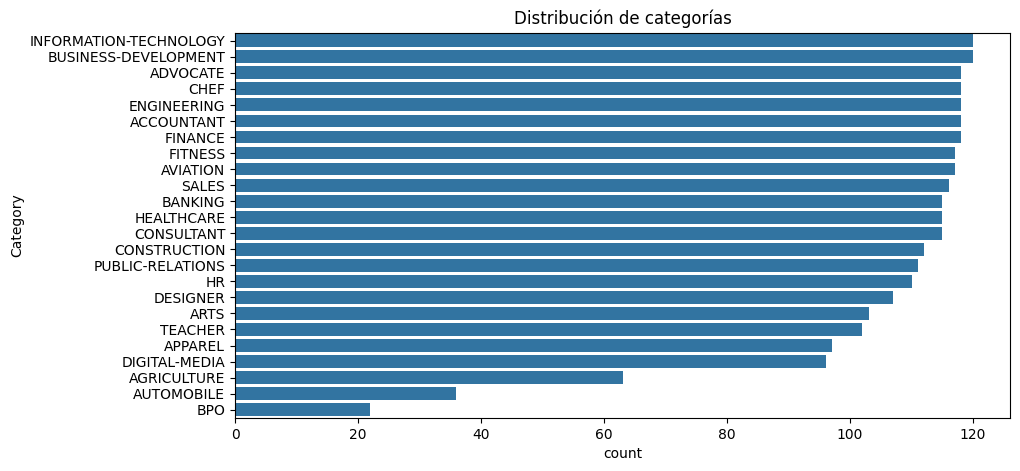

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(y="Category", data=df, order=df['Category'].value_counts().index)
plt.title("Distribución de categorías")
plt.show()


In [7]:
df['char_len'] = df['Resume_str'].str.len()
df['word_len'] = df['Resume_str'].str.split().apply(len)

df[['char_len','word_len']].describe()

,char_len,word_len
count,2484.000000,2484.000000
mean,6295.308776,811.325684
std,2769.251458,371.006906
min,21.000000,0.000000
25%,5160.000000,651.000000
50%,5886.500000,757.000000
75%,7227.250000,933.000000
max,38842.000000,5190.000000


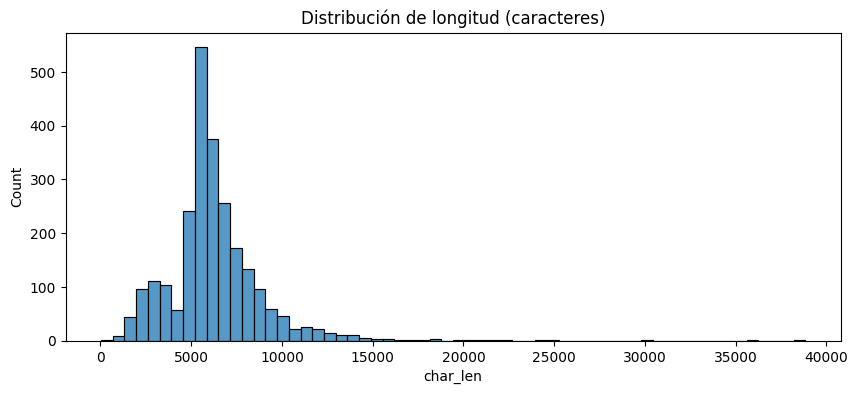

In [24]:

plt.figure(figsize=(10,4))
sns.histplot(df['char_len'], bins=60)
plt.title("Distribución de longitud (caracteres)")
plt.show()


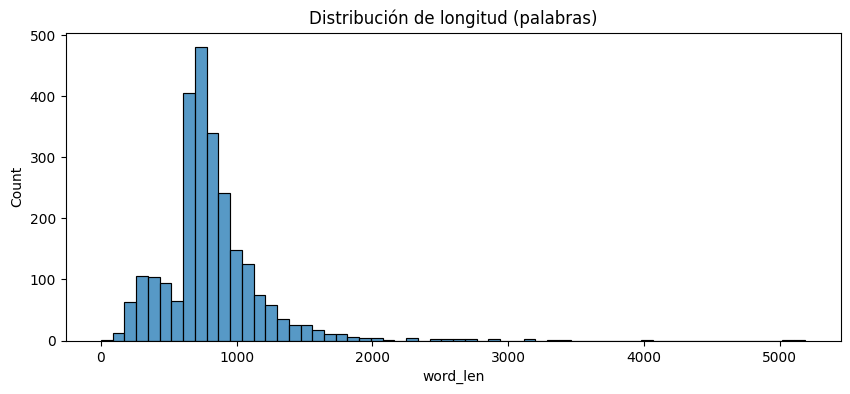

In [8]:

plt.figure(figsize=(10,4))
sns.histplot(df['word_len'], bins=60)
plt.title("Distribución de longitud (palabras)")
plt.show()


In [30]:
# Supongamos que tu DataFrame se llama df y tiene la columna Resume_str
def mean_word_length(text):
    words = word_tokenize(str(text))
    if len(words) == 0:
        return 0
    return np.mean([len(w) for w in words])

def mean_sentence_length(text):
    sentences = sent_tokenize(str(text))
    if len(sentences) == 0:
        return 0
    return np.mean([len(word_tokenize(s)) for s in sentences])

df["mean_word_length"] = df["Resume_str"].apply(mean_word_length)
df["mean_sentence_length"] = df["Resume_str"].apply(mean_sentence_length)

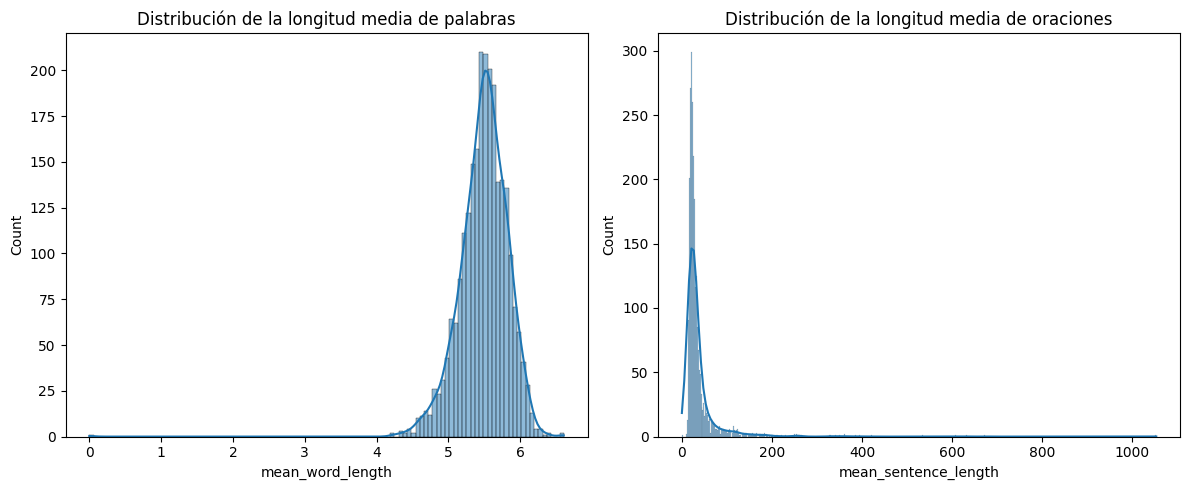

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df["mean_word_length"], ax=axes[0], kde=True)
axes[0].set_title("Distribución de la longitud media de palabras")

sns.histplot(df["mean_sentence_length"], ax=axes[1], kde=True)
axes[1].set_title("Distribución de la longitud media de oraciones")

plt.tight_layout()
plt.show()

C:\Users\TAWTOCA\AppData\Local\Temp\ipykernel_11852\321138041.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='word', x='count', data=freq_df, palette='mako')


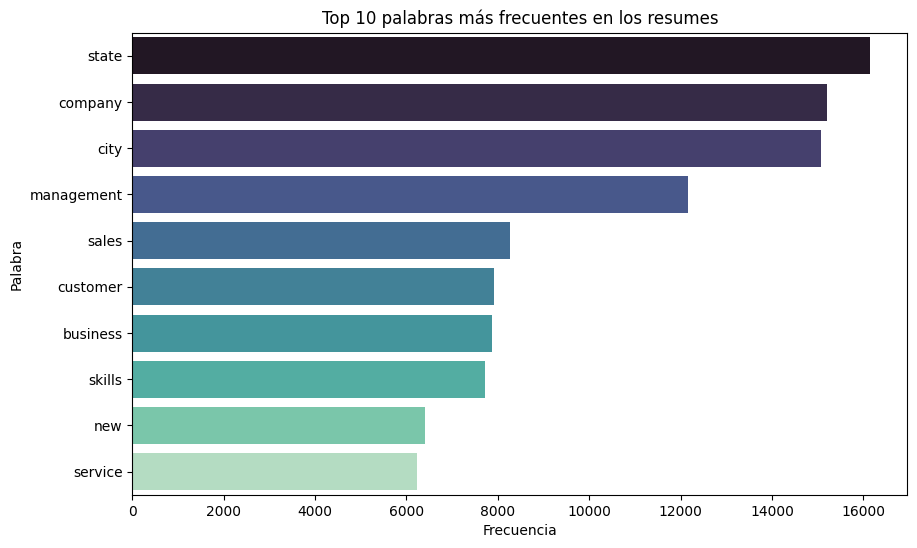

In [34]:
# --- Vectorizar el texto ---
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), max_features=50)
X = cv.fit_transform(df['Resume_str'].fillna(''))

# --- Sumar ocurrencias de cada palabra ---
word_freq = X.toarray().sum(axis=0)

# --- Crear DataFrame ordenado ---
freq_df = pd.DataFrame({
    'word': cv.get_feature_names_out(),
    'count': word_freq
}).sort_values(by='count', ascending=False).head(10)

# --- Graficar ---
plt.figure(figsize=(10,6))
sns.barplot(y='word', x='count', data=freq_df, palette='mako')
plt.title('Top 10 palabras más frecuentes en los resumes')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()


C:\Users\TAWTOCA\AppData\Local\Temp\ipykernel_11852\2218849941.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='bigram', x='count', data=bigram_df, palette='crest')


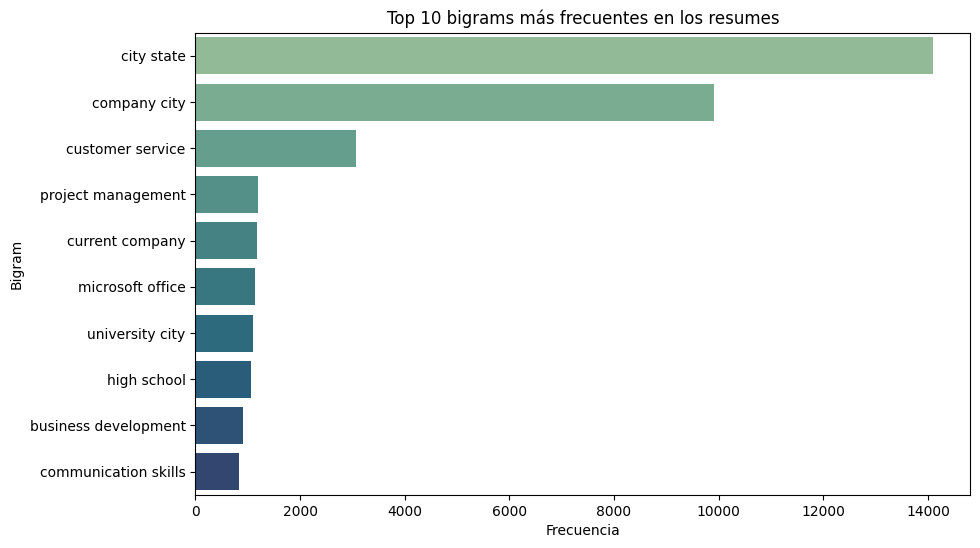

In [35]:
# --- Vectorizar bigrams ---
cv2 = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=100)
bgs = cv2.fit_transform(df['Resume_str'].fillna(''))

# --- Calcular frecuencias ---
bigram_freq = bgs.toarray().sum(axis=0)

# --- Crear DataFrame ordenado ---
bigram_df = pd.DataFrame({
    'bigram': cv2.get_feature_names_out(),
    'count': bigram_freq
}).sort_values(by='count', ascending=False).head(10)

# --- Graficar ---
plt.figure(figsize=(10,6))
sns.barplot(y='bigram', x='count', data=bigram_df, palette='crest')
plt.title('Top 10 bigrams más frecuentes en los resumes')
plt.xlabel('Frecuencia')
plt.ylabel('Bigram')
plt.show()


C:\Users\TAWTOCA\AppData\Local\Temp\ipykernel_11852\1133898812.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='trigram', x='count', data=trigram_df, palette='mako')


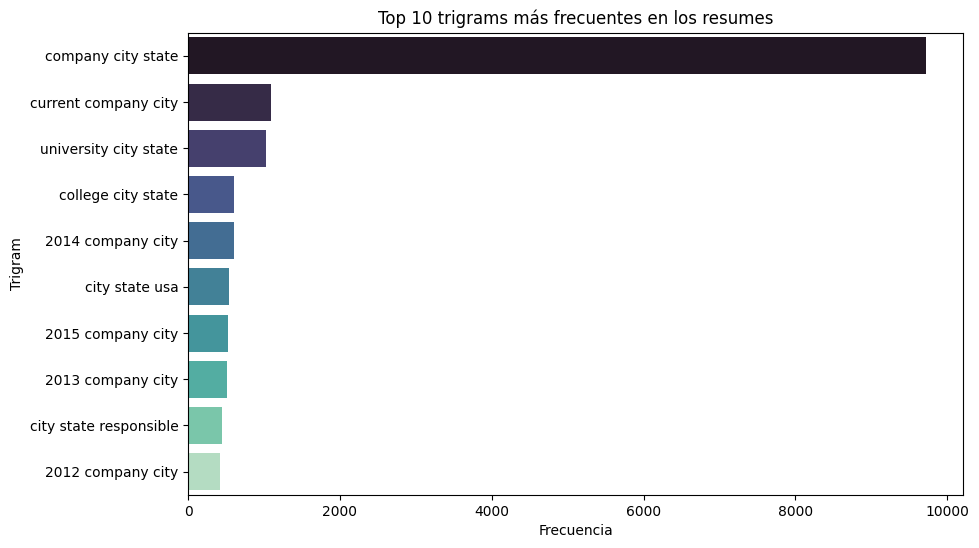

In [36]:
# --- Vectorizar trigrams ---
cv3 = CountVectorizer(stop_words='english', ngram_range=(3,3), max_features=100)
tgs = cv3.fit_transform(df['Resume_str'].fillna(''))

# --- Calcular frecuencias ---
trigram_freq = tgs.toarray().sum(axis=0)

# --- Crear DataFrame ordenado ---
trigram_df = pd.DataFrame({
    'trigram': cv3.get_feature_names_out(),
    'count': trigram_freq
}).sort_values(by='count', ascending=False).head(10)

# --- Graficar ---
plt.figure(figsize=(10,6))
sns.barplot(y='trigram', x='count', data=trigram_df, palette='mako')
plt.title('Top 10 trigrams más frecuentes en los resumes')
plt.xlabel('Frecuencia')
plt.ylabel('Trigram')
plt.show()


(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

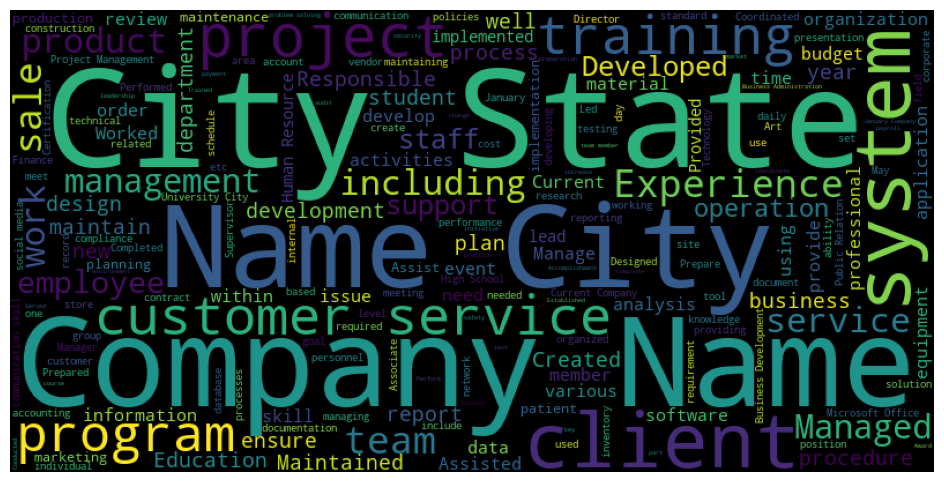

In [10]:

text = " ".join(df['Resume_str'].dropna().tolist())
wc = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(12,6)); plt.imshow(wc); plt.axis('off')


## Preprocesamiento

In [39]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convertir a minúsculas
    text = str(text).lower()
    # Eliminar HTML y etiquetas extrañas
    text = re.sub(r'<.*?>', ' ', text)
    # Eliminar números
    text = re.sub(r'\d+', ' ', text)
    # Eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Eliminar caracteres especiales y múltiples espacios
    text = re.sub(r'\s+', ' ', text).strip()
    # Eliminar stopwords
    words = [w for w in text.split() if w not in stop_words]
    return ' '.join(words)

# Aplicar la limpieza
df["clean_resume"] = df["Resume_str"].apply(clean_text)

In [42]:
df.to_csv("resumes_preprocessed.csv", index=False)

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parámetros
MAX_WORDS = 20000   # número máximo de palabras en el vocabulario
MAX_LEN = 200       # longitud máxima de secuencia (se ajusta luego según distribución de longitudes)

# Tokenizador
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_resume"])

# Convertir a secuencias
X_seq = tokenizer.texts_to_sequences(df["clean_resume"])
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Ejemplo de secuencia: {X_seq[0][:20]}")
print(f"Forma final de X_pad: {X_pad.shape}")


Ejemplo de secuencia: [154, 18484, 182, 154, 717, 89, 755, 10, 13, 22, 76, 16, 1604, 10, 13, 5, 4390, 3183, 334, 5168]
Forma final de X_pad: (2484, 200)


In [ ]:
import gensim.downloader as api
import numpy as np

# Descargar modelo preentrenado
w2v = api.load("word2vec-google-news-300")  # 300 dimensiones

# Crear matriz de embeddings
embedding_dim = 300
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        if word in w2v:
            embedding_matrix[i] = w2v[word]
